In [102]:
import pandas as pd
import numpy as np
import os

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model
import torch
import matplotlib.pyplot as plt

seed = 42
TARGET_GENE = "BRCA1"
df = None

In [103]:
DATASET_NAME = 'dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))
df = df[df["GeneSymbol"] == TARGET_GENE]
df.to_csv(os.path.join(config.DATA_DIR, f"{TARGET_GENE}.csv"))


In [104]:
if df is None:
    df = pd.read_csv(os.path.join(config.DATA_DIR, f"{TARGET_GENE}.csv"))

target_array = df[TARGET_FEATURE]
df.drop(columns=[TARGET_FEATURE, "GeneSymbol"], inplace=True)
ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = []
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference']
pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

In [105]:
# Split the data
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

In [106]:
# Make sure input has no nan (it messed up the nn)
pd.isna(df.to_numpy()).any()

np.False_

In [107]:
# Fit pipeline and transform data
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)
transformed_X_training = torch.Tensor(transformed_X_training)
transformed_X_validation = torch.Tensor(feature_processor.transform(validation_data))
transformed_X_test = torch.Tensor(feature_processor.transform(test_data))

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [129]:
# We only have one embedding input size right now, since we're doing this by hand anyways we can probably hard-code each one
# going forward. Maybe there is a way to automate this.
HIDDEN_SIZES = [64, 32]
DROPOUT = 0
embedding_dimension_mapping = np.array([])
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

2025-11-01 18:56:54.292 | INFO     | gene_variation_effects.modeling.train:run_training_loop:59 - Epoch 1: accuracy=0.8125
2025-11-01 18:56:54.292 | INFO     | gene_variation_effects.modeling.train:run_training_loop:60 - Epoch 1: validation accuracy=0.7500
2025-11-01 18:56:54.292 | INFO     | gene_variation_effects.modeling.train:run_training_loop:61 - Epoch 1: validation loss=0.6568
2025-11-01 18:56:54.296 | INFO     | gene_variation_effects.modeling.train:run_training_loop:59 - Epoch 2: accuracy=0.5625
2025-11-01 18:56:54.296 | INFO     | gene_variation_effects.modeling.train:run_training_loop:60 - Epoch 2: validation accuracy=0.7188
2025-11-01 18:56:54.296 | INFO     | gene_variation_effects.modeling.train:run_training_loop:61 - Epoch 2: validation loss=0.6528
2025-11-01 18:56:54.297 | INFO     | gene_variation_effects.modeling.train:run_training_loop:59 - Epoch 3: accuracy=0.3750
2025-11-01 18:56:54.297 | INFO     | gene_variation_effects.modeling.train:run_training_loop:60 - Epoch

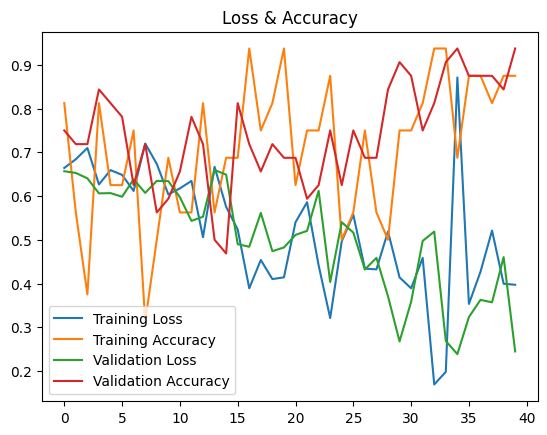

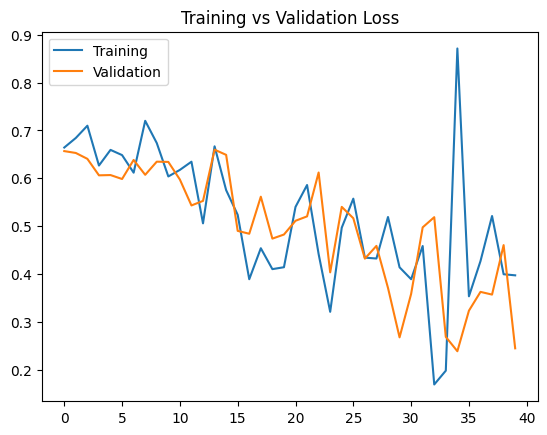

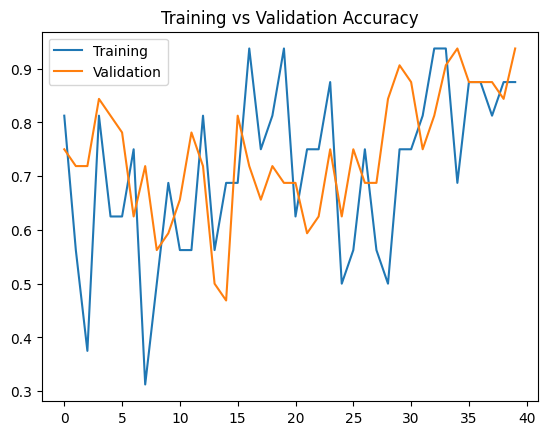

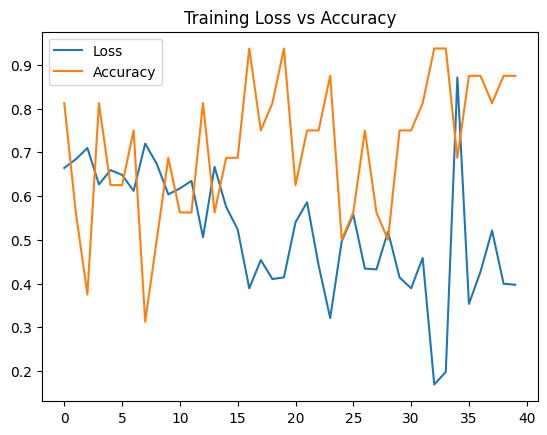

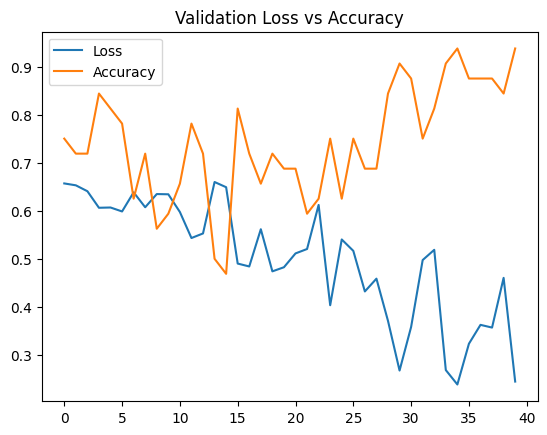

<Figure size 640x480 with 0 Axes>

In [130]:
# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]
BATCH_SIZE = 16
PATIENCE = 5

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
optimal_model_dict, training_losses, val_losses, training_accuracies, val_accuracies = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, validation_target_array, embedding_features_indices, patience=PATIENCE, 
    optimizer=optimizer)
torch.save(optimal_model_dict, "../models/BRCA1model.pth")

plt.plot(training_losses, label="Training Loss")
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(val_losses, label="Validation Loss")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Loss & Accuracy")
plt.legend()
plt.show()
plt.clf()


plt.plot(training_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(training_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
plt.clf()

plt.plot(training_losses, label="Loss")
plt.plot(training_accuracies, label="Accuracy")
plt.title("Training Loss vs Accuracy")
plt.legend()
plt.show()
plt.clf()

plt.plot(val_losses, label="Loss")
plt.plot(val_accuracies, label="Accuracy")
plt.title("Validation Loss vs Accuracy")
plt.legend()
plt.show()
plt.clf()

In [110]:
# Recreate the model structure
model.load_state_dict(torch.load("../models/BRCA1model.pth"))

<All keys matched successfully>

In [131]:
avg_loss, accuracy = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices)
avg_loss, accuracy

(0.3791946205444092, tensor(0.8760))